In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, accuracy_score, plot_confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder,StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from joblib import load

from functions import load_clean_XY

# Predicting & understanding water pump failures for the Tanzanian Ministry of Water
<hr>
<br/>

Team members:
<ul/>
  <li/>Ahmad Samiee</li>
  <li/>Nick Hall</li>
</ul>

###### NOTE: Refer to the README.md for information on where to obtain the data

### Table of Contents
<ol/>
  <li/>Business Objective</li>
  <li/>Data Preparation & Model Building</li>
  <ol/>
    <li/>Ahmad</li>
    <li/>Nick</li>
  </ol>
  <li/>Evaluation</li>
</ol>

### Business Objective

With this project, our team set out to build a model that could <b/>1)</b> accurately predict failures and repair needs of water pumps across Tanzania, as well as <b/>2)</b> understand <i/>why</i> these pumps were failing. With this information, we aimed to provide the model to the Tanzanian Ministry of Water for their own use, as well as inform them of potential ways these numbers can be reduced in the future.

We decided to use <b/>recall</b> as our primary metric for model success, since our aim was to capture as many broken/in-disrepair wells as possible, as what is most important is to ensure those who need clean drinking water have access to it. We also used <b/>accuracy</b> as a secondary metric to judge our models.

### Data Preparation & Model Building

To tackle this problem, our team decided it would be best to prepare the data and create models individually, then compare our models' metrics against each other.

#### Ahmad

In [2]:
features = pd.read_csv('../data/4910797b-ee55-40a7-8668-10efd5c1b960.csv')
target = pd.read_csv('../data/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
combined_df = pd.concat([features,target['status_group']],axis=1)
combined_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


After extensive EDA, Ahmad decided to drop the 'extraction_type', 'extraction_type_group', 'payment', 'quality_group', 'quantity_group', 'source_type', 'waterpoint_type_group', 'funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', 'recorded_by', 'scheme_name', 'id', and 'num_private' columns as he determined they would be unhelpful in training his model to distinguish between OK wells and those in need of repair.
###### See ahmad_eda.ipynb to see more about his EDA

In [3]:
cols_to_drop = ['extraction_type', 'extraction_type_group', 'payment', 
                'quality_group', 'quantity_group', 'source_type', 
                'waterpoint_type_group','funder','installer','wpt_name',
                'subvillage','lga','ward','recorded_by','scheme_name','id', 
                'num_private']

keep_columns = [col for col in combined_df.columns if(col not in cols_to_drop)]

combined_final_df = combined_df[keep_columns].copy()

combined_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   gps_height             59400 non-null  int64  
 3   longitude              59400 non-null  float64
 4   latitude               59400 non-null  float64
 5   basin                  59400 non-null  object 
 6   region                 59400 non-null  object 
 7   region_code            59400 non-null  int64  
 8   district_code          59400 non-null  int64  
 9   population             59400 non-null  int64  
 10  public_meeting         56066 non-null  object 
 11  scheme_management      55523 non-null  object 
 12  permit                 56344 non-null  object 
 13  construction_year      59400 non-null  int64  
 14  extraction_type_class  59400 non-null  object 
 15  ma

Ahmad discovered that there were a large number of construction years recorded as 0, obviously a placeholder for an unknown quantity. He aimed to approximate missing construction years with the 'date_recorded' column and engineer this into a new feature of the DataFrame.

construction year greater 0:  0.6513636363636364
construction year = 0: 0.34863636363636363


4771.0

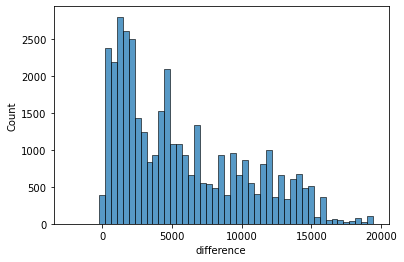

In [4]:
date_df = combined_final_df[['date_recorded','construction_year']].copy()
date_df['rev_construction_year'] = date_df[
    'construction_year'].map(
    lambda x: pd.to_datetime(x,format='%Y').toordinal() if(x>0) else None)

date_df['rev_date_recorded'] = date_df[
    'date_recorded'].map(lambda x: pd.to_datetime(x).toordinal())
above_zero = date_df[date_df['construction_year'] > 0].copy()
print('construction year greater 0: ', len(above_zero)/len(date_df))
print('construction year = 0:',date_df['rev_construction_year'].isna().sum()/len(date_df))
above_zero['difference'] = above_zero['rev_date_recorded'] - above_zero['rev_construction_year']
sns.histplot(data=above_zero,x='difference');
difference = above_zero['rev_date_recorded'].median() - above_zero['rev_construction_year'].median()
difference

In [5]:
# Create a new column 'rev_construction_year' and if year greater than zero 
# change to ordinal and if equal to zero
combined_final_df['rev_date_recorded'] = combined_final_df[
    'date_recorded'].map(lambda x: pd.to_datetime(x).toordinal())
combined_final_df['rev_construction_year'] = combined_final_df[
    'construction_year'].map(
    lambda x: pd.to_datetime(x,format='%Y').toordinal() if(x>0) else None)

combined_final_df.rev_construction_year.fillna(
    value=(combined_final_df.rev_date_recorded - difference),inplace=True)

combined_final_df[['date_recorded','rev_date_recorded',
                   'construction_year','rev_construction_year']]


,date_recorded,rev_date_recorded,construction_year,rev_construction_year
0,2011-03-14,734210,1999,729755.0
1,2013-03-06,734933,2010,733773.0
2,2013-02-25,734924,2009,733408.0
3,2013-01-28,734896,1986,725007.0
4,2011-07-13,734331,0,729560.0
...,...,...,...,...
59395,2013-05-03,734991,1999,729755.0
59396,2011-05-07,734264,1996,728659.0
59397,2011-04-11,734238,0,729467.0
59398,2011-03-08,734204,0,729433.0


Next, Ahmad finalized his data to train his models on.

In [6]:
# create a 'rev_status' colum, assign 0 if 'status_group' equals functional
# and assign 1 if 'status_grou' eqauls not functional or functional needs repair 
combined_final_df['rev_status'] = combined_final_df['status_group'].map(lambda x: 0 if(x == 'functional') else 1)
combined_final_df['rev_status'].value_counts()

0    32259
1    27141
Name: rev_status, dtype: int64

In [7]:
# drop redundent columns 'construction_year', 'status_groups' and date_recorded
# split dataframe into features and target copies
final_features = combined_final_df.drop(['construction_year','status_group',
                                   'rev_status','date_recorded'],axis=1).copy()
final_target = combined_final_df['rev_status'].copy()
final_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   gps_height             59400 non-null  int64  
 2   longitude              59400 non-null  float64
 3   latitude               59400 non-null  float64
 4   basin                  59400 non-null  object 
 5   region                 59400 non-null  object 
 6   region_code            59400 non-null  int64  
 7   district_code          59400 non-null  int64  
 8   population             59400 non-null  int64  
 9   public_meeting         56066 non-null  object 
 10  scheme_management      55523 non-null  object 
 11  permit                 56344 non-null  object 
 12  extraction_type_class  59400 non-null  object 
 13  management             59400 non-null  object 
 14  management_group       59400 non-null  object 
 15  pa

Ahmad would use this data to first build a dummy model, then move on to more advanced ones.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(final_features,
                                                   final_target,
                                                   random_state=1234,
                                                   stratify=final_target)

X_train_nums = X_train.select_dtypes(['float64','int64'])
X_train_cats = X_train.select_dtypes('object')

In [9]:
def plot_roc_curve(y_train,y_predict,model_name):
    #fig,ax = plt.subplots(figsize=(10,10))
    fpr, tpr, thresholds = roc_curve(y_train, y_predict)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='Base Model')
    display.plot();   

Here, Ahmad built his Pipelines, using the <b/>median</b> to impute missing numerical data, and using the <b/>most frequent</b> item for categorical.

In [10]:
# Setup numerical and categorical pipeline and incorporate both into
# ColumnTransformer
num_pipeline = Pipeline(steps=[
    ('num_impute',SimpleImputer(strategy='median')),
    ('num_ss',StandardScaler())])

cat_pipeline = Pipeline(steps=[
    ('cat_impute',SimpleImputer(strategy='most_frequent')),
    ('cat_ohe', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

cat_pipeline2 = Pipeline(steps=[
    ('cat_impute',SimpleImputer(strategy='most_frequent')),
    ('cat_ord',OrdinalEncoder())])

trans = ColumnTransformer(transformers=[
    ('numerical',num_pipeline,X_train_nums.columns),
    ('categorical',cat_pipeline,X_train_cats.columns)])

trans2 = ColumnTransformer(transformers=[
    ('numerical',num_pipeline,X_train_nums.columns),
    ('categorical',cat_pipeline,X_train_cats.columns)])

In [11]:
### COMMENTED OUT FOR SAKE OF BREVITY

# Fit base_model, do validation on train and predict score for test
# Plot confusion matrix and ROC curve for base_model

#base_model_pipe = Pipeline(steps=[
#    ('trans',trans),
#    ('dummy_model',DummyClassifier(random_state=1234,strategy='prior'))])

#base_model_pipe.fit(X_train,y_train)
#y_train_base_pred = base_model_pipe.predict(X_train)
#scores = cross_validate(base_model_pipe,X_train,y_train,scoring=['recall',
#                                                                'accuracy'])
#fit_time = 'fit_time'
#score_time = 'score_time'
#recall = 'test_recall'
#accuracy = 'test_accuracy'
#print(f'Validation train mean recall score: {scores[recall].mean()}')
#print(f'Validation train mean accuracy score: {scores[accuracy].mean()}')
#print(f'Validation train mean fit time: {scores[fit_time].mean()}')
#print(f'Validation train mean score time: {scores[score_time].mean()}')
#print('='*40)
#print(f'Train recall score: {recall_score(y_train,y_train_base_pred)}')
#print(f'Train accuracy score: {base_model_pipe.score(X_train, y_train)}')
#print('='*40)
#plot_confusion_matrix(base_model_pipe,X_train,y_train);
#plot_roc_curve(y_train,y_train_base_pred,'Base_model')

Finally, Ahmad would build three types of models: a Decision Tree model, a KNN model, and a Logistic Regression model.

In [12]:
### COMMENTED OUT FOR SAKE OF BREVITY

#dt_model_pipe = Pipeline(steps=[
#    ('trans',trans),
#    ('dtree_model',DecisionTreeClassifier(random_state=1234))])

#dt_parameters = {
#    'dtree_model__max_depth': [60,90],   #tried 3,5,10,30,60(best),90
#    'dtree_model__min_impurity_decrease' : [0,0.3],
#    'dtree_model__max_features' : ['auto','sqrt']
#}

#dtree_grid_model = GridSearchCV(estimator = dt_model_pipe,
#                          param_grid=dt_parameters,refit='recall',
#                         scoring=['recall','accuracy'])

#dtree_grid_model.fit(X_train,y_train)
#y_train_dt_pred = dtree_grid_model.predict(X_train)
#cv_results = pd.DataFrame([dtree_grid_model.cv_results_])
#accuracy = 'mean_test_accuracy'
#print('='*40)
#print(f'Train recall score: {dtree_grid_model.best_score_}')
#print(f'Train accuracy score: {cv_results[accuracy].mean()}')
#print(f'Best paramets: {dtree_grid_model.best_params_}')
#print('='*40)
#print(confusion_matrix(y_train,y_train_dt_pred))
#plot_confusion_matrix(dtree_grid_model,X_train,y_train);
#plot_roc_curve(y_train,y_train_dt_pred,'Decision Tree')
#cv_results

In [13]:
### COMMENTED OUT FOR SAKE OF BREVITY

#knn_model_pipe = Pipeline(steps=[
#    ('trans',trans),
#    ('knn_model',KNeighborsClassifier())])

#knn_parameters = {
#    'knn_model__n_neighbors' : [3], #tried 3(best),5,10
#    'knn_model__weights' : ['uniform','distance'],   #tried ['uniform','distance'] distance(best)
#    'knn_model__leaf_size' : [15,30,45]
#}

#knn_grid_model = GridSearchCV(estimator = knn_model_pipe,
#                          param_grid=knn_parameters,refit='recall',
#                          scoring=['recall','accuracy'])

#knn_grid_model.fit(X_train,y_train)
#y_train_knn_pred = knn_grid_model.predict(X_train)
#cv_results = pd.DataFrame([knn_grid_model.cv_results_])
#accuracy = 'mean_test_accuracy'
#print('='*40)
#print(f'Train recall score: {knn_grid_model.best_score_}')
#print(f'Train accuracy score: {cv_results[accuracy].mean()}')
#print(f'Best paramets: {knn_grid_model.best_params_}')
#print('='*40)
#print(confusion_matrix(y_train,y_train_knn_pred))
#plot_confusion_matrix(knn_grid_model,X_train,y_train);
#plot_roc_curve(y_train,y_train_knn_pred,'k-Nearest Neighbors')
#cv_results

In [14]:
### COMMENTED OUT FOR SAKE OF BREVITY

#lr_model_pipe = Pipeline(steps=[
#    ('trans2',trans2),
#    ('lr_model',LogisticRegression())])

#lr_parameters = {
#    'lr_model__penalty' : ['l2','l1','elasticnet'],
#    'lr_model__random_state' : [1234],
#    'lr_model__C' : [1e3,1e6,1e9],  #tried 1e-3,1,10e3 and 10e9
#    'lr_model__max_iter' : [1e2,1e3,1e4],  #tried 1e4
#    'lr_model__solver' : ['newton-cg','lbfgs','liblinear'] #tried also  and 
#}

#lr_grid_model = GridSearchCV(estimator = lr_model_pipe,
#                          param_grid=lr_parameters,refit='recall',
#                          scoring=['recall','accuracy'])

#lr_grid_model.fit(X_train,y_train)
#y_train_lr_pred = lr_grid_model.predict(X_train)
#cv_results = pd.DataFrame([lr_grid_model.cv_results_])
#accuracy = 'mean_test_accuracy'
#print('='*40)
#print(f'Train recall score: {lr_grid_model.best_score_}')
#print(f'Train accuracy score: {cv_results[accuracy].mean()}')
#print(f'Best paramets: {lr_grid_model.best_params_}')
#print('='*40)
#print(confusion_matrix(y_train,y_train_lr_pred))
#plot_confusion_matrix(lr_grid_model,X_train,y_train);
#plot_roc_curve(y_train,y_train_lr_pred,'Logistic Regression')
#cv_results

The models scored the following recall scores:
<ul/>
  <li/><b/>DT</b>: .7512</li>
  <li/><b/>KNN</b>: .7482</li>
  <li/><b/>LR</b>: .6920</li>
</ul>

#### Nick

Nick opted to write a function to clean and load his data. He decided to drop the 'id', 'num_private', 'construction_year', 'scheme_name', 'extraction_type', 'extraction_type_group', 'payment_type', 'water_quality', 'quantity_group', 'source', and 'waterpoint_type_group' columns; very similar to how Ahmad cleaned his data, with some exceptions.

One notable one is that, on seeing that over 35% of the data in 'construction_year' column was missing, Nick decided to <b/>not</b> include this in his training data.
###### See functions.py for more information on how Nick cleaned his data

In [15]:
X, y, comb_df = load_clean_XY('../data/4910797b-ee55-40a7-8668-10efd5c1b960.csv', '../data/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
comb_df.head()

,status_group,needs_repair,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,permit,extraction_type_class,management,management_group,payment,quality_group,quantity,source_type,source_class,waterpoint_type
0,functional,1,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,0.0,gravity,vwc,user-group,pay annually,good,enough,spring,groundwater,communal standpipe
1,functional,1,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,1.0,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe
2,functional,1,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,1.0,gravity,vwc,user-group,pay per bucket,good,enough,dam,surface,communal standpipe multiple
3,non functional,0,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,1.0,submersible,vwc,user-group,never pay,good,dry,borehole,groundwater,communal standpipe multiple
4,functional,1,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,1.0,gravity,other,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.5, random_state=1)

X_train_num = X_train.select_dtypes(['float64','int64', 'int32', 'int'])
X_train_cat = X_train.select_dtypes('object')

Here, Nick built his pipelines; however, Nick opted to use the <b/>mean</b> to impute missing numerical data, and to use <b/>"None"</b> to fill missing values for categorical data.

In [17]:
pipeline_num = Pipeline([('impute_num', SimpleImputer(strategy='mean')), \
  ('scaler_num', StandardScaler())])

pipeline_cat = Pipeline([('impute_cat', SimpleImputer(strategy='constant', fill_value='None')), \
  ('ohe_cat', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocess_transform = ColumnTransformer([('numeric', pipeline_num, X_train_num.columns.tolist()), \
  ('categorical', pipeline_cat, X_train_cat.columns.tolist())])

pipeline_LR = Pipeline([('preprocess_LR', preprocess_transform), \
  ('model_LR', LogisticRegression(random_state=1))])

pipeline_KNN = Pipeline([('preprocess_KNN', preprocess_transform), \
  ('model_KNN', KNeighborsClassifier())])

pipeline_DT = Pipeline([('preprocess_DT', preprocess_transform), \
  ('model_DT', DecisionTreeClassifier())])

pipeline_RF = Pipeline([('preprocess_RF', preprocess_transform), \
  ('model_RF', RandomForestClassifier())])

Due to technical difficulties, Nick only ended up being able to create one Logistic Regression model.

In [18]:
def validate_model(search, X_train, X_test, y_train, y_test):
  search.fit(X_train, y_train)
  y_test_pred = search.predict(X_test)
  cv_results = pd.DataFrame([search.cv_results_])
  # accuracy = 'mean_test_accuracy'
  print(f'Train recall score: {search.best_score_}')
  print(f'Test recall score: {recall_score(y_test, y_test_pred)}')
  print(f'Best parameters: {search.best_params_}')
  plot_confusion_matrix(search, X_train, y_train)
  return search.cv_results_, search.best_params_

In [19]:
### COMMENTED OUT FOR SAKE OF BREVITY

#params_LR = {'model_LR__penalty': ['l2', 'none']} # got warnings for l1 & elasticnet

#search_LR = GridSearchCV(pipeline_LR, params_LR, cv=10, scoring=['recall', 'accuracy'], refit='recall')

#cv_LR, best_params_LR = validate_model(search_LR, X_train, X_test, y_train, y_test)

This model performed the best out of any model, scoring a train recall score of <b/>.8472</b> and a test recall score of <b/>.8381</b>. This model was then saved with joblib for future use.

### Evaluation

Since Nick's Logistic Regression model performed the best out of all created models, a closer look was taken at the model.

In [20]:
X, y, comb_df = load_clean_XY('../data/4910797b-ee55-40a7-8668-10efd5c1b960.csv', '../data/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.5, random_state=1)

search_LR = load('./models/search_LR.joblib')

y_train_pred = search_LR.predict(X_train)
y_test_pred = search_LR.predict(X_test)

In [21]:
print(f'Train recall score: {recall_score(y_train, y_train_pred)}')
print(f'Test recall score: {recall_score(y_test, y_test_pred)}')
print(f'Train accuracy score: {accuracy_score(y_train, y_train_pred)}')
print(f'Test accuracy score: {accuracy_score(y_test, y_test_pred)}')

Train recall score: 0.9383718767437534
Test recall score: 0.8380657160570366
Train accuracy score: 0.9035353535353535
Test accuracy score: 0.7920202020202021


From this model, the coefficients were able to be obtained since this was a parametric model.

In [22]:
coefs_LR = search_LR.best_estimator_.named_steps.model_LR.coef_.tolist()[0]
dict_coefs_LR = dict(zip(list(X.columns), coefs_LR))
dict_coefs_LR

{'amount_tsh': 0.056698643007545006,
 'date_recorded': 0.11690939289757442,
 'funder': -0.17204008317969535,
 'gps_height': -0.24016351180101295,
 'installer': -0.23901387944658126,
 'longitude': 0.14146123974311225,
 'latitude': 0.14391665718330585,
 'wpt_name': 0.16186416973942985,
 'basin': 0.059677007154556976,
 'subvillage': 0.38261851612813114,
 'region': -0.3265517289899449,
 'region_code': 0.13095036199280807,
 'district_code': -0.36521943551542113,
 'lga': -0.4578687840799932,
 'ward': 0.3685226026718488,
 'population': 0.38886101822156477,
 'public_meeting': 0.23879078012598154,
 'recorded_by': 0.08407752995405184,
 'scheme_management': -0.38024949989040574,
 'permit': -0.6696484351654063,
 'extraction_type_class': -0.28050244363904114,
 'management': 0.8884304873667742,
 'management_group': 0.03054341585912643,
 'payment': -0.7934895667084235,
 'quality_group': -0.7888579388773486,
 'quantity': -0.030820758635276686,
 'source_type': -0.13444792079937123,
 'source_class': 0.6

Some of the highest weighted coefficients were 'management', 'payment', and 'permit', so their relationship with 'repair_status' was investigated.

### Management and repair status

In [23]:
repair_management = comb_df[['needs_repair', 'management']]
repair_management.head()

,needs_repair,management
0,1,vwc
1,1,wug
2,1,vwc
3,0,vwc
4,1,other


In [24]:
repair_management.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [25]:
repair_management.loc[repair_management.needs_repair == 1].management.value_counts()

vwc                 20425
wug                  3906
water board          2170
wua                  1751
private operator     1476
parastatal           1020
other                 505
water authority       446
company               267
unknown               224
trust                  46
other - school         23
Name: management, dtype: int64

In [26]:
repair_perc_by_management = repair_management.loc[repair_management.needs_repair == 1].management.value_counts() / repair_management.management.value_counts()
repair_perc_by_management.sort_values(ascending=False, inplace=True)
repair_perc_by_management

private operator    0.748858
water board         0.739857
wua                 0.690730
wug                 0.599540
other               0.598341
trust               0.589744
parastatal          0.576923
vwc                 0.504234
water authority     0.493363
unknown             0.399287
company             0.389781
other - school      0.232323
Name: management, dtype: float64

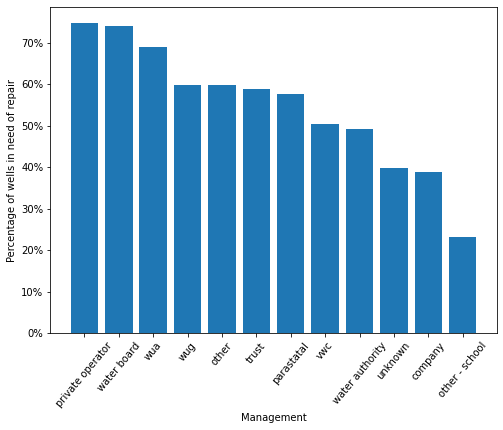

In [27]:
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(repair_perc_by_management.index, repair_perc_by_management.values)
ax.set_xlabel('Management')
ax.set_ylabel('Percentage of wells in need of repair')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xticks(rotation=50);

### Payment and repair

In [28]:
repair_payment = comb_df[['needs_repair', 'payment']]
repair_payment.head()

,needs_repair,payment
0,1,pay annually
1,1,never pay
2,1,pay per bucket
3,0,never pay
4,1,never pay


In [29]:
repair_perc_by_payment = repair_payment.loc[repair_payment.needs_repair == 1].payment.value_counts() / repair_payment.payment.value_counts()
repair_perc_by_payment.sort_values(ascending=False, inplace=True)
repair_perc_by_payment

pay annually             0.752334
pay per bucket           0.677796
pay monthly              0.660482
pay when scheme fails    0.620593
other                    0.579696
never pay                0.448911
unknown                  0.432512
Name: payment, dtype: float64

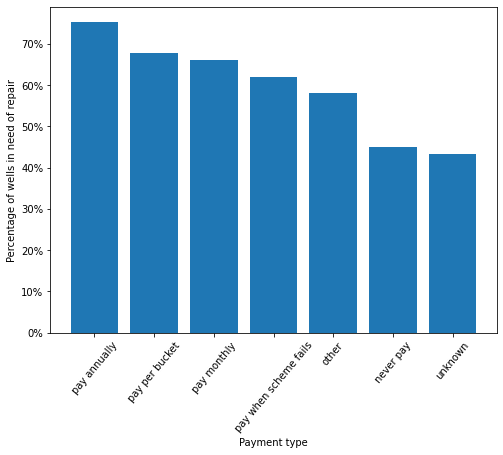

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(repair_perc_by_payment.index, repair_perc_by_payment.values)
ax.set_xlabel('Payment type')
ax.set_ylabel('Percentage of wells in need of repair')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xticks(rotation=50);

### Permit status and repair

In [31]:
repair_permit = comb_df[['needs_repair', 'permit']]
repair_permit.head()

,needs_repair,permit
0,1,0.0
1,1,1.0
2,1,1.0
3,0,1.0
4,1,1.0


In [32]:
repair_perc_by_permit = repair_permit.loc[repair_permit.needs_repair == 1].permit.value_counts() / repair_permit.permit.value_counts()
repair_perc_by_permit.sort_values(ascending=False, inplace=True)
repair_perc_by_permit

1.0    0.554437
0.0    0.517094
Name: permit, dtype: float64

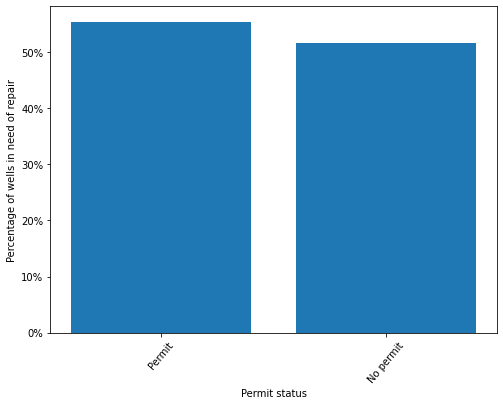

In [33]:
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(repair_perc_by_permit.index.map({0: 'No permit', 1: 'Permit'}), repair_perc_by_permit.values)
ax.set_xlabel('Permit status')
ax.set_ylabel('Percentage of wells in need of repair')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xticks(rotation=50);

From these findings, we inferred that certain water managements were a primary indicator of wells in disrepair, and that permit status and payment type also had a smaller (but real) correlation with repair status.

With these findings, we are able to make actionable feedback to the Tanzanian Water Ministry, as well as provide them with a working model that can be used in the future.